In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from operator import itemgetter
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
def logloss(X, y, w):
    '''
        Loss function
        Input: matrix X, a vector y and a vector w
        Output: integer loss
    '''
    m = X.shape[0]
    h = sigmoid(np.dot(X, w))
    return (-1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

def sigmoid(x):
    '''
        Sigmoid activation function
        Input: float or vector
        Output: float [0, 1]
    '''
    return 1 / (1 + np.exp(-x))

def predict_probs(X, w):
    '''
        Transforms(maps) weights into probabilities
        Input: Matrix X, vector w
        Output: float [0, 1]
    '''
    return sigmoid(np.dot(X, w))

def predicts(X, w, eps=0.5):
    '''
        Predicts a label for a sample or set of samples given a model and a threshold
        Input: Matrix X, vector w, float eps
        Output: Label 0 or 1
    '''
    return predict_probs(X, w) >= eps

def accuracy(X, y, w):
    '''
        Computes the accuracy of the model predictions
        Input: Matrix X, vector y, vector w
        Outputs: float [0,1]
    '''
    p = predicts(X, w)
    return (p == y).mean()

def logit(X, y, w=np.random.uniform(-0.5,0.5, 2000), alpha=0.1, loss_function=logloss, num_epochs=300, batch_size =20000):
    '''
        Logistic regression function
        All parameters are set to the defaults given by the assignment description
        Takes the parameters and execute logistic regression. 
        Returns the best model, the array of training costs and validation costs

        Input: Matrix X, vector y, vector w, float alpha, function loss_function
                integer num_epochs, integer batch_size
        Output: vector best_model, vector train_costs, vector val_costs
    '''
    num_parameters = len(X[0])
    train_costs = []
    val_costs = []
    best_model = w
    best_cost = 1
    
    for i in range(num_epochs):
        for j in range(0, len(X), batch_size):
            start = j * batch_size
            end = j * batch_size + batch_size
            batch_X = X[start:end]
            batch_y = y[start:end]
            
            h = sigmoid(np.dot(batch_X, w))
            gradient = np.dot(batch_X.T, (h - batch_y))
            w -= (alpha / batch_size) * gradient
        train_costs.append(loss_function(X, y, w))
        val_costs.append(loss_function(X_val, y_val, w))
        
        if val_costs[-1] < best_cost:
            best_model = w
            best_cost = val_costs[-1]
            
    return best_model, train_costs, val_costs

In [3]:
def read_files(address):
    '''
        Reads all files in a given a directory correcting encoding
        Input: string adress
        Output: list[string] 
    '''
    my_files = os.listdir(address)
    return [open("{}/{}".format(address,i),'r', encoding='utf-8').read() for i in my_files]

def shuffle_arr(arr, seed=314):
    '''
        Shuffles a list
        Input: list arr
    '''
    np.random.seed(seed)
    np.random.shuffle(arr)

def clean_and_split(text):
    '''
        Takes a string, removes white spaces, makes it lowercase and splits given space
        Input: string
        Returns: list of strings
    '''
    return text.strip().lower().split()

def vocabulary_builder(collection, size=2000):
    '''
        Takes a list of strings and creates a simple counter and vocabulary
        Input: list of strings, integer size
        output: list _vocab, list id2word, dict word2id
    '''
    vocab = {}
    for sentence in collection:
        for word in clean_and_split(sentence):
            try:
                vocab[word] += 1
            except:
                vocab[word] = 1
    _vocab = sorted(vocab.items(), key=itemgetter(1), reverse=True)[:size]
    id2word = [i[0] for i in _vocab]
    word2id = {id2word[i]:i for i in range(len(id2word))}
    return _vocab, id2word, word2id

def make_set(pos, neg, vocab, shuffle=True):
    '''
        Cleans, shuffles and transforms a text into the correct format for learning
        Input: list pos, list neg, list vocab, boolean shuffle
    '''
    X = [clean_and_split(i) for i in pos + neg]
    y = [1] *len(pos) + [0] * len(neg)
    if shuffle:
        shuffle_arr(X)
        shuffle_arr(y)
    return to_bow(X, vocab), np.array(y)

def to_bow(X, vocab):
    '''
        Input: matrix X, list vocab
        Output: Binary array indicating if the word appear in the sample
    '''
    
    return np.array([[i in sample for i in vocab] for sample in X])

In [4]:
try:
    #Tries to load files from disk, if not existent then computes
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(open("data.pkl", "rb"))
    id2word, word2id = pickle. load(open("aux.pkl", "rb"))
except FileNotFoundError:
    #Loading train and test set from files
    train_pos = read_files('./train/pos')
    train_neg = read_files('./train/neg')
    test_pos = read_files('./test/pos')
    test_neg = read_files('./test/neg')

    #shuffling to avoid "Sorted Bias" 
    shuffle_arr(train_pos)
    shuffle_arr(train_neg)

    #Splitting the training set into training and validation
    val_pos, val_neg = train_pos[:2500], train_neg[:2500]
    train_pos, train_neg = train_pos[2500:], train_neg[2500:]
    
    #Builds vocabulary and util maps
    vocab, id2word, word2id = vocabulary_builder(train_pos + train_neg)
    
    #transforming the sets into a binary representation
    X_train, y_train = make_set(train_pos, train_neg, id2word)
    X_val, y_val = make_set(val_pos,val_neg, id2word, False)
    X_test, y_test = make_set(test_pos, test_neg, id2word, False)
    
    #dump files to disk
    pickle.dump( (id2word, word2id), open("aux.pkl", "wb"))
    pickle.dump((X_train, y_train, X_val, y_val, X_test, y_test), open("data.pkl", "wb"))

CPU times: user 2min 24s, sys: 3min 8s, total: 5min 32s
Wall time: 5min 33s


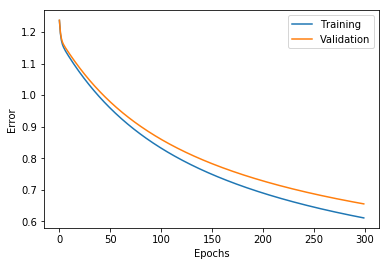

Accuracy: 0.70912


In [12]:
#Computes the logistic Regression given the 
%time w, c, vc = logit(X_train, y_train)
fig, ax = plt.subplots()
plot(c, label='Training')
plot(vc, label='Validation')

plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Error')
show()
print("Accuracy: {}".format(accuracy(X_test, y_test, w)))

In [6]:
#Left for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
model = LogisticRegression(n_jobs=-1, max_iter=300)
%time model.fit(X_train, y_train)
predicted_classes = model.predict(X_test)
print(accuracy_score(y_test, predicted_classes))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 2.2 s, sys: 129 ms, total: 2.33 s
Wall time: 2.35 s
0.84704
